<a href="https://colab.research.google.com/github/Aniket6334/Fake-News-Detector/blob/main/Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

About the Dataset:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
           1: Fake news
           0: real News

**Import the dependencies**

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

**Data Pre-processing**

In [5]:
# loading the dataset to a pandas dataframe
news_dataset = pd.read_csv('/content/train.csv',  encoding='latin1', low_memory = False)
!ls /content

sample_data  test.csv  train.csv


In [6]:
news_dataset.shape

(20800, 5)

In [7]:
# print the first 5 rows of the dataframe
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didnât Even See Comeyâs...,Darrell Lucus,House Dem Aide: We Didnât Even See Comeyâs...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
# counting the number of missing values in the dataset
news_dataset.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [9]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

In [10]:
news_dataset.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [11]:
# @title Class distribution
print("Class Distribution:")
print(news_dataset['label'].value_counts())

Class Distribution:
label
1    10413
0    10387
Name: count, dtype: int64


In [12]:
# merging the author and news title for better detection
news_dataset['content'] = news_dataset['author']+' '+ news_dataset['title']

In [13]:
print(news_dataset['content'])

0        Darrell Lucus House Dem Aide: We Didnât Even...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a âPoster C...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [14]:
# separate the data & label column axis = 0 means removing row, 1 means column
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [15]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didnât Even See Comeyâs...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a âPoster Child For White...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macyâs Is Said to Receive Takeover Approach ...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

**Stemming:**
**Reducing a word to its root word**

In [16]:
port_stem = PorterStemmer()

In [17]:
# creating a function called stemming (33)
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [18]:
news_dataset['content'] = news_dataset['content'].apply(stemming)

In [19]:
print(news_dataset['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [20]:
# separating the data and label
X = news_dataset['content'].values
Y = news_dataset['label'].values

In [21]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [22]:
print(Y)

[1 0 1 ... 0 1 1]


In [23]:
# @title TF - IDF
# converting the textual data to numerical data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(X)

X = vectorizer.transform(X)

In [24]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 403438 stored elements and shape (20800, 137225)>
  Coords	Values
  (0, 2381)	0.1579497730750911
  (0, 2404)	0.255043502142135
  (0, 19127)	0.21499546955631474
  (0, 19134)	0.255043502142135
  (0, 23971)	0.14434999392666764
  (0, 24032)	0.21499546955631474
  (0, 29291)	0.21045871819040535
  (0, 29292)	0.21262384331520603
  (0, 31299)	0.15820239698811886
  (0, 31303)	0.255043502142135
  (0, 39564)	0.13643906501104486
  (0, 39621)	0.255043502142135
  (0, 56501)	0.12791573703275527
  (0, 56544)	0.255043502142135
  (0, 61762)	0.14493897388987523
  (0, 61766)	0.21499546955631474
  (0, 68518)	0.1708289011920322
  (0, 68540)	0.255043502142135
  (0, 71216)	0.21262384331520603
  (0, 71223)	0.255043502142135
  (0, 107508)	0.1500484720341119
  (0, 107520)	0.255043502142135
  (0, 126506)	0.1665749169793067
  (1, 11594)	0.18049964510831348
  (1, 11701)	0.31496380436318755
  :	:
  (20797, 122071)	0.049681464100517374
  (20797, 136630)	0.0

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

**Training the Model : Logistic Regression**

In [26]:
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)

LogisticRegression()

**Training the Model : Random Forest Classifier**

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [28]:
# @title Cross-Validation to verify accuracy - Logistic Regression
scores = cross_val_score(lr_model, X_train, Y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.96814904 0.9672476  0.97295673 0.97115385 0.97205529]
Mean Accuracy: 0.9703125


In [29]:
# @title Cross-Validation to verify accuracy - Random Forest Classifier
scores = cross_val_score(rf_model, X_train, Y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.9921875  0.99459135 0.9921875  0.9936899  0.99609375]
Mean Accuracy: 0.99375


**Evaluation**

**Accuracy Scores : Logistic Regression & Random Forest Classifier**

In [38]:
# accuracy score on the training data : Logistic Regression
X_train_prediction_lr = lr_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_lr, Y_train)
print('Accuracy score over training data over logistic regression model: ', training_data_accuracy*100, '%')

Accuracy score over training data over logistic regression model:  98.9423076923077 %


In [39]:
# @title Analyze incorrect predictions (Train) : Logistic Regression
incorrect_preds = X_train[(X_train_prediction_lr != Y_train)]
incorrect_df = pd.DataFrame({'Text': incorrect_preds, 'True Label': Y_train[(X_train_prediction_lr != Y_train)],
                             'Predicted Label': X_train_prediction_lr[(X_train_prediction_lr != Y_train)]})
print("Misclassified Samples:")
incorrect_df.head()

Misclassified Samples:


,Text,True Label,Predicted Label
0,<Compressed Sparse Row sparse matrix of dtype ...,0,1
1,<Compressed Sparse Row sparse matrix of dtype ...,0,1
2,<Compressed Sparse Row sparse matrix of dtype ...,0,1
3,<Compressed Sparse Row sparse matrix of dtype ...,1,0
4,<Compressed Sparse Row sparse matrix of dtype ...,0,1


In [40]:
# accuracy score on the training data : Random Forest Classifier
X_train_prediction_rf = rf_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction_rf, Y_train)
print('Accuracy score over training data over random forest classifier: ', training_data_accuracy*100, '%')

Accuracy score over training data over random forest classifier:  100.0 %


In [41]:
# @title Analyze incorrect predictions (Train) : Random Forest Classifier
incorrect_preds = X_train[(X_train_prediction_rf != Y_train)]
incorrect_df = pd.DataFrame({'Text': incorrect_preds, 'True Label': Y_train[(X_train_prediction_rf != Y_train)],
                             'Predicted Label': X_train_prediction_rf[(X_train_prediction_rf != Y_train)]})
print("Misclassified Samples:")
incorrect_df.head()

Misclassified Samples:


,Text,True Label,Predicted Label


In [42]:
# accuracy score on the test data : Logistic Regression
X_test_prediction_lr = lr_model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction_lr, Y_test)
print('Accuracy score of the test data over logistic regression model: ', test_data_accuracy*100, '%')

Accuracy score of the test data over logistic regression model:  97.45192307692308 %


In [43]:
# @title Analyze incorrect predictions (Test) : Logistic Regression
import pandas as pd
incorrect_preds = X_test[(X_test_prediction_lr != Y_test)]
incorrect_df = pd.DataFrame({'Text': incorrect_preds, 'True Label': Y_test[(X_test_prediction_lr != Y_test)],
                             'Predicted Label': X_test_prediction_lr[(X_test_prediction_lr != Y_test)]})
print("Misclassified Samples:")
incorrect_df

Misclassified Samples:


,Text,True Label,Predicted Label
0,<Compressed Sparse Row sparse matrix of dtype ...,0,1
1,<Compressed Sparse Row sparse matrix of dtype ...,0,1
2,<Compressed Sparse Row sparse matrix of dtype ...,0,1
3,<Compressed Sparse Row sparse matrix of dtype ...,0,1
4,<Compressed Sparse Row sparse matrix of dtype ...,0,1
...,...,...,...
101,<Compressed Sparse Row sparse matrix of dtype ...,1,0
102,<Compressed Sparse Row sparse matrix of dtype ...,0,1
103,<Compressed Sparse Row sparse matrix of dtype ...,0,1
104,<Compressed Sparse Row sparse matrix of dtype ...,0,1


In [44]:
# accuracy score on the test data : Random Forest Classifier
X_test_prediction_rf = rf_model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction_rf, Y_test)
print('Accuracy score of the test data over logistic regression model: ', test_data_accuracy*100, '%')

Accuracy score of the test data over logistic regression model:  99.54326923076923 %


In [45]:
# @title Analyze incorrect predictions (Test) : Random Forest Classifier
import pandas as pd
incorrect_preds = X_test[(X_test_prediction_rf != Y_test)]
incorrect_df = pd.DataFrame({'Text': incorrect_preds, 'True Label': Y_test[(X_test_prediction_rf != Y_test)],
                             'Predicted Label': X_test_prediction_rf[(X_test_prediction_rf != Y_test)]})
print("Misclassified Samples:")
incorrect_df

Misclassified Samples:


,Text,True Label,Predicted Label
0,<Compressed Sparse Row sparse matrix of dtype ...,0,1
1,<Compressed Sparse Row sparse matrix of dtype ...,1,0
2,<Compressed Sparse Row sparse matrix of dtype ...,0,1
3,<Compressed Sparse Row sparse matrix of dtype ...,0,1
4,<Compressed Sparse Row sparse matrix of dtype ...,0,1
5,<Compressed Sparse Row sparse matrix of dtype ...,0,1
6,<Compressed Sparse Row sparse matrix of dtype ...,0,1
7,<Compressed Sparse Row sparse matrix of dtype ...,0,1
8,<Compressed Sparse Row sparse matrix of dtype ...,0,1
9,<Compressed Sparse Row sparse matrix of dtype ...,0,1


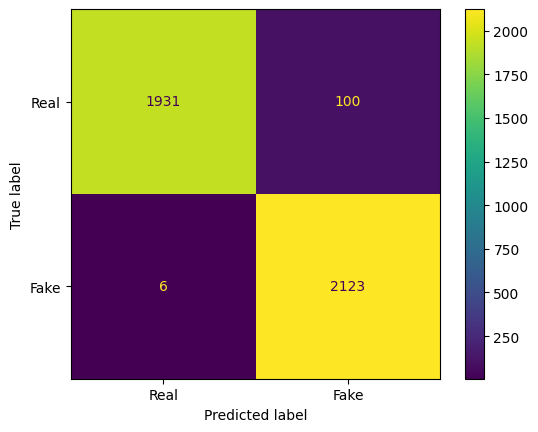

In [37]:
# @title Confusion Matrix : Logistic Regression
cm = confusion_matrix(Y_test, X_test_prediction_lr)
ConfusionMatrixDisplay(cm, display_labels=['Real', 'Fake']).plot()

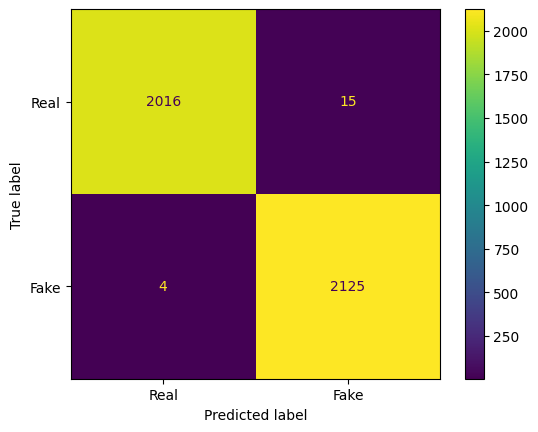

In [46]:
# @title Confusion Matrix : Random Forest Classifier
cm = confusion_matrix(Y_test, X_test_prediction_rf)
ConfusionMatrixDisplay(cm, display_labels=['Real', 'Fake']).plot()

**Making a predictive system**

In [56]:
X_new = X_test[1234]

prediction = lr_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


In [57]:
print(Y_test[1234])

1
